# Bing Pilot Notebook
Purpose is to use Selenium to query names to test for ads via Bing.<br>
By: Jonathan Lo<br>
Date: 11/2/23

## Overhead

In [1]:
# Imports
import re
import logging
import os

import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from collections import defaultdict
from tqdm.notebook import tqdm

from util import *

In [2]:
# Setup logger
if not os.path.exists('../logs/'):
    os.mkdir('../logs/')
if not os.path.exists('../logs/bing-pilot.log'):
    open('../logs/bing-pilot.log', 'a').close()

logging.basicConfig(
    filename='../logs/bing-pilot.log',
    filemode='w',
    format='%(asctime)s %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG
)

In [3]:
# Setup Webdriver Options
options = Options()

options.add_argument("--disable-notifications")
options.add_argument("--incognito")
options.add_experimental_option("prefs", {"plugins.plugins_list": [{"enabled": False, "name": "Chrome PDF Viewer"}]})
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option('useAutomationExtension', False)
options.add_argument("--start-maximized")
options.add_argument("--disable-blink-features")
options.add_argument('--disable-extensions')
options.add_argument("--no-sandbox")

options.binary_location = "/usr/local/bin/webdriver"

In [4]:
# Setup Selenium
print("Internet connected: ", internet())
driver = webdriver.Chrome(options=options)

Internet connected:  True


## Collection

### Generating Names

In [5]:
# Init names
path = "./../data/pilot-names.json"
white_female_names = generate_names(path, 'white', 'female')
white_male_names = generate_names(path, 'white', 'male')
black_female_names = generate_names(path, 'black', 'female')
black_male_names = generate_names(path, 'black', 'male')
all_names = {
    "wf": white_female_names,
    "wm": white_male_names,
    "bf": black_female_names,
    "bm": black_male_names
}

### Querying

In [6]:
def parse_bing_ads(raw_html, query):
    """ Parses the doman.TLD and the title, URL from the HTML
    """
    compiled = defaultdict(list)
    pattern = r'(?:http[s]?://)?(?:www\.)?([\w-]+\.[\w-]+)' # Matches the domain and TLD of a URL
    ads = BeautifulSoup(raw_html).select('.sb_add')
    for ad in ads:
        try:
            title = ad.select_one('h2').text
            link = ad.select_one('.b_adurl').text
            match = re.search(pattern, link)
            domain = match.group(1) if match else 'ERROR'
            compiled[domain].append((title, link))
        except Exception as e:
            logging.debug(f'Failed to parse ad HTML on query: {query}')
    return compiled

In [7]:
# Querying all names and obtaining the ads on the page (est. 4min)
all_ads = [['Name', 'Group', 'Ad Domain', 'Ad Title', 'Ad Link']]
for group, names in tqdm(all_names.items()):
    for name in tqdm(names):
        query = f"{name} public records"
        raw_html = bing_search(query, driver)
        parsed = parse_bing_ads(raw_html, query)
        for domain, ad_items in parsed.items():
            for ad_opts in ad_items:
                all_ads.append([name, group, domain, ad_opts[0], ad_opts[1]])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

## Analysis

### Labelling

In [8]:
# Init DF
df = pd.DataFrame(all_ads[1:], columns=all_ads[0])

In [9]:
# Label
mapping = {'wf': ('White', 'Female'), 'wm': ('White', 'Male'), 'bf': ('Black', 'Female'), 'bm': ('Black', 'Male')}
df['Race'] = df['Group'].map(mapping).str[0]
df['Sex'] = df['Group'].map(mapping).str[1]
df['Criminal Ad'] = df['Ad Title'].str.lower().str.contains('criminal')

In [10]:
# Showing dataframe
df.head()

,Name,Group,Ad Domain,Ad Title,Ad Link,Race,Sex,Criminal Ad
0,Allison Smith,wf,recordsquarry.com,Public Records Search Free | Free Public Recor...,https://recordsquarry.com,White,Female,False
1,Allison Smith,wf,courtrecords.us,Public Court Records Access | Public Court Rec...,https://www.courtrecords.us.org/Court/Records,White,Female,False
2,Allison Smith,wf,criminalrecords.us,"Enter Name- No Records, No Fee | Search Anyone...",https://www.criminalrecords.us.org/Criminal/Re...,White,Female,False
3,Allison Johnson,wf,publicrecords.info,County Public Records Online | Enter Name. No ...,https://www.publicrecords.info/public-records/...,White,Female,False
4,Allison Johnson,wf,publicrecords.info,County Public Records Online | Enter Name. No ...,https://www.publicrecords.info/public-records/...,White,Female,False


### Breakdown

In [32]:
# Show breakdowns
counts_r = df.groupby(['Race'])['Name'].count()
counts_rs = df.groupby(['Race', 'Sex'])['Name'].count()
display(counts_r.to_frame())
display(counts_rs.to_frame())

,Name
Race,
Black,497
White,423


Name
Race  Sex         
Black Female   259
      Male     238
White Female   214
      Male     209

In [33]:
# Finding only criminal ads
crime_df = df[df['Criminal Ad']]
crime_r = crime_df.groupby(['Race'])['Criminal Ad'].count()
crime_rs = crime_df.groupby(['Race', 'Sex'])['Criminal Ad'].count()
display(crime_r.to_frame())
display(crime_rs.to_frame())

,Criminal Ad
Race,
Black,6
White,11


Criminal Ad
Race  Sex                
Black Female            2
      Male              4
White Female            4
      Male              7

In [37]:
# Finding distributions
display((crime_r / counts_r).to_frame())
display((crime_rs / counts_rs).to_frame())

,0
Race,
Black,0.012072
White,0.026005


0
Race  Sex             
Black Female  0.007722
      Male    0.016807
White Female  0.018692
      Male    0.033493

<Axes: xlabel='Race'>

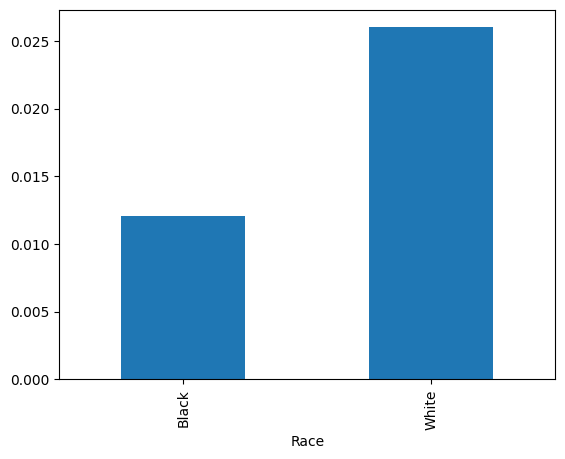

In [43]:
(crime_r/counts_r).plot(kind='bar')

<Axes: xlabel='Race,Sex'>

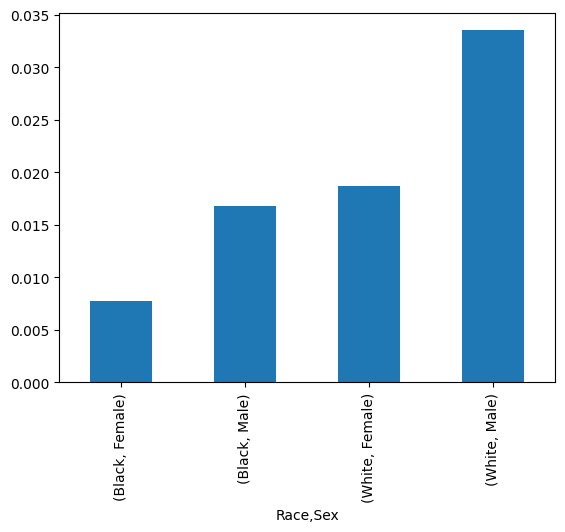

In [44]:
(crime_rs/counts_rs).plot(kind='bar')